## Notebook 5: `5_Model_Testing`       


In the last notebook, we trained some deep learning models on a sample of dataset. This notebook describes process of testing a model using real world data.     

This process will be applied to all models, here I am showing the process for testing logistic regression model.   

In order to test the logistic regression model, tweets were scrapped from twitter and the model was used to predict the sentiment for the tweets. The tweets were scrapped for a specific brand to understand the public sentiment about that brand.    

Tweets were scrapped for last seven days and sentiment was predicted based on these tweets over last 7 days.   

Following is the table of contents for this notebook

### Table of Contents 

<br>   

1. [Scrapping Data using twitter's API](#API)  
2. [Clean Scrapped Data](#clean)
3. [Data Transformation](#transformation)                  
4. [Predict sentiment of scrapped tweets](#sentiment)                          
5. [Conclusion](#conclusion)    



Import required libraries. 

In [306]:
#importing libraries
import os

#data cleaning
import pandas as pd 
import numpy as np
from datetime import datetime

#data scrapping from twitter
import tweepy as tw
import config #credentials for twitter API

#text processing 
import re 
import nltk

import joblib

import matplotlib.pyplot as plt


## Scrapping Data using twitter's API <a name="API"></a>

I am using twitter's API v2 to scrape data for testing my model. Let's first connect to twitter's API. 

In [114]:
#authenticate credentials 
client = tw.Client(bearer_token=config.bearer_token)

For the basic twitter developer account, twitter's API allow to scrape a maximum of 250 minutes every 15 minutes. Also, you can only scrape tweets for last 7 days only. I am creating a list of timestamps for last seven days. This list will be used to scrape data fro last seven days using twitter's API. Let's define some parameters to be used inside twitter's scrapper. 

In [301]:
#create a list of timestamps for the last 7 days
n_days = 7
date_range = [datetime.now() - pd.Timedelta(days=x) for x in range(n_days)]
date_range.append((datetime.now() - pd.Timedelta(days=n_days-1)).replace(hour=0, minute=0, second=0)) #starts the 7th day at 12 AM
date_range.reverse()

# Define the search term and the date_since date as variables
query = "#Shopify"
max_results = 14

In [302]:
#check out the time stamps 
date_range

[datetime.datetime(2022, 3, 25, 0, 0, 0, 15622),
 datetime.datetime(2022, 3, 25, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 26, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 27, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 28, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 29, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 30, 10, 35, 41, 15622),
 datetime.datetime(2022, 3, 31, 10, 35, 41, 15622)]

Let's define a function which will get `max_results` number of tweets for each day during the last seven days. The tweets will be scraped for the term `query`.

In [303]:
# collect tweets 
def get_tweets(query, start_time, end_time, max_results):
    """Function to get tweets using tweeter's API
    Parameter
    ---------
    query: str, the matching words or combination of words from tweet
    start_time: timestamp, time stamp after which tweets need to be scraped
    end_time: timestamp, time stamp before which tweets need to be scraped
    max_results: int, maximum number of tweets to be scrapped
    
    Returns: the tweet object containing information about the tweet"""

    try:
        tweets = client.search_recent_tweets(
                                            query=query, max_results=max_results, start_time=start_time,
                                            end_time=end_time, tweet_fields=["created_at", "lang"])
        #return the list of english tweets 
        return [tweet.text for tweet in tweets.data if tweet.lang == 'en']
    except:
        print(f'No matching tweets found for {end_time.date()}')
    

Using this function get tweets for #Shopify `query` for last seven days. 

In [304]:
#get tweet for n number of days 
tweets = {}
for i in range(len(date_range)-1):
    start_time = date_range[i]
    end_time = date_range[i+1]
    tweets[end_time] = get_tweets(query, start_time, end_time, max_results)
    print(f'extracted tweets until {date_range[i+1]}', end='\r')
    

In [305]:
#checkout the tweet object 
tweets

{datetime.datetime(2022, 3, 25, 10, 35, 41, 15622): ['RT @MondoPlayer: Relative Position Setting | Shopify Developer #ShopifySeller #ShopifyStore #OnlineStore #Shopify [Video] https://t.co/0INn…',
  'RT @MondoPlayer: Relative Position Setting | Shopify Developer #ShopifySeller #ShopifyStore #OnlineStore #Shopify [Video] https://t.co/0INn…',
  'RT @MondoPlayer: Relative Position Setting | Shopify Developer #ShopifySeller #ShopifyStore #OnlineStore #Shopify [Video] https://t.co/0INn…',
  'Relative Position Setting | Shopify Developer #ShopifySeller #ShopifyStore #OnlineStore #Shopify [Video] https://t.co/0INnj7QxfQ',
  'RT @xericgit: got mockup to start implementing it on Shopify:\n\n#SoftwareEngineering #coding #Python #JavaScript #ReactJS #Flutter #WomenWho…',
  'RT @MondoPlayer: Brave Bitesize #85- Digital Marketing News: Should I use a Shopify developer for my website? #EcommerceMarketing #Marketin…',
  '@TerryWhenman @g_gosden @owen_whiteley Hello Guys! I am Tarek Khan and I am an e

Put these tweets into a dataframe. Notice that I have to use `Dataframe.from_dict` to convert the dictionary to a dataframe. This is because of the different lengths of the tweet lists for each of the days. 

In [211]:
tweets_df = pd.DataFrame.from_dict(tweets, orient='index')

In [212]:
tweets_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
2022-03-23 11:08:02.727825,"The problem might not be your products, your b...","Check out my Gig on Fiverr: fix shopify bugs, ...",Check out my Gig on Fiverr: design Shopify sto...,The latest The shopify ecommerce development D...,RT @Vedenyo: Do you need a promo? it's easy a...,$SHOP enters bearish trend #Shopify https://t....,#Discount: PULUZ 4 in 1 Live Broadcast LED Sel...,RT @WebsitesToolz: How to create awesome video...,Learn how. link in bio\n#ecomera #ecommerce #s...,None,None,None,None
2022-03-24 11:08:02.727825,@HelenPollitt1 Are you wondering on how to gro...,@DsMatie Are you wondering on how to grow your...,RT @Ghanshy93013534: Next Milestone Completed!...,Check out my Gig on Fiverr: create responsive ...,RT @Ghanshy93013534: Next Milestone Completed!...,"Next Milestone Completed! Thanks, Upwork\n#upw...","I am Niffy, I am a website designer. I can des...",The latest The shopify ecommerce development D...,"These phone cases are impact-resistant, Keeps ...","RT @NOWPayments_io: Hey #BabyDogeArmy, you the...","RT @ophirbucai: A very wise man once said, (an...","RT @ophirbucai: A very wise man once said, (an...",RT @shopifreaks: THIS JUST IN: Instagram now l...
2022-03-25 11:08:02.727825,The latest The Shopify Success Daily! https://...,"push your self because , nno one else is going...",RT @WebsitesToolz: Top 7 ClickFunnels alternat...,"RT @NOWPayments_io: Hey #BabyDogeArmy, you the...",Check out my Gig on Fiverr: do shopify marketi...,Check out my Gig on Fiverr: create shopify dro...,Check it out! paidmarketer will increase sales...,RT @MondoPlayer: Relative Position Setting | S...,RT @MondoPlayer: Relative Position Setting | S...,RT @MondoPlayer: Relative Position Setting | S...,Relative Position Setting | Shopify Developer ...,RT @xericgit: got mockup to start implementing...,None
2022-03-26 11:08:02.727825,"WE BUILD, GROW AND MARKET YOUR IDEAS!\nFor mor...",RT @MyFiscalFitness: 5 Ways To Help Protect E-...,RT @Product26025280: #ArtificialIntelligence #...,RT @Product26025280: #ArtificialIntelligence #...,5 Ways To Help Protect E-commerce Stores From ...,RT @fikrcamp: 🚀 We have taken the initiative t...,RT @Product26025280: #ArtificialIntelligence #...,RT @Product26025280: #ArtificialIntelligence #...,RT @WebsitesToolz: Top 5 Social Proof tools fo...,RT @Product26025280: #ArtificialIntelligence #...,None,None,None
2022-03-27 11:08:02.727825,2-Seater Garden Adirondack Chair Solid Fir Woo...,Check out my Gig on Fiverr: do ecommerce marke...,The latest The Shopify Success Daily! https://...,RT @WebsitesToolz: 20 brands using customer ex...,5-Tier Book Cabinet Black 60x30x175 cm Chipboa...,The latest The shopify ecommerce development D...,Check it out! paidmarketer will increase sales...,I wanted to see how the #LinkPop link-in-bios ...,Dot Short Sleeve Mid-length Dress (Color:Black...,Ghostrunner (PS5) | Video Games\n\nhttps://t.c...,Olympia Chia Mugs Charcoal 340ml (Pack of 6) |...,None,None


## Clean Scrapped Data <a name="clean"></a>

In [213]:
#replace None values with np.NaN
tweets_df.replace([None], np.nan, inplace=True)
tweets_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
2022-03-23 11:08:02.727825,"The problem might not be your products, your b...","Check out my Gig on Fiverr: fix shopify bugs, ...",Check out my Gig on Fiverr: design Shopify sto...,The latest The shopify ecommerce development D...,RT @Vedenyo: Do you need a promo? it's easy a...,$SHOP enters bearish trend #Shopify https://t....,#Discount: PULUZ 4 in 1 Live Broadcast LED Sel...,RT @WebsitesToolz: How to create awesome video...,Learn how. link in bio\n#ecomera #ecommerce #s...,NaN,NaN,NaN,NaN
2022-03-24 11:08:02.727825,@HelenPollitt1 Are you wondering on how to gro...,@DsMatie Are you wondering on how to grow your...,RT @Ghanshy93013534: Next Milestone Completed!...,Check out my Gig on Fiverr: create responsive ...,RT @Ghanshy93013534: Next Milestone Completed!...,"Next Milestone Completed! Thanks, Upwork\n#upw...","I am Niffy, I am a website designer. I can des...",The latest The shopify ecommerce development D...,"These phone cases are impact-resistant, Keeps ...","RT @NOWPayments_io: Hey #BabyDogeArmy, you the...","RT @ophirbucai: A very wise man once said, (an...","RT @ophirbucai: A very wise man once said, (an...",RT @shopifreaks: THIS JUST IN: Instagram now l...
2022-03-25 11:08:02.727825,The latest The Shopify Success Daily! https://...,"push your self because , nno one else is going...",RT @WebsitesToolz: Top 7 ClickFunnels alternat...,"RT @NOWPayments_io: Hey #BabyDogeArmy, you the...",Check out my Gig on Fiverr: do shopify marketi...,Check out my Gig on Fiverr: create shopify dro...,Check it out! paidmarketer will increase sales...,RT @MondoPlayer: Relative Position Setting | S...,RT @MondoPlayer: Relative Position Setting | S...,RT @MondoPlayer: Relative Position Setting | S...,Relative Position Setting | Shopify Developer ...,RT @xericgit: got mockup to start implementing...,NaN
2022-03-26 11:08:02.727825,"WE BUILD, GROW AND MARKET YOUR IDEAS!\nFor mor...",RT @MyFiscalFitness: 5 Ways To Help Protect E-...,RT @Product26025280: #ArtificialIntelligence #...,RT @Product26025280: #ArtificialIntelligence #...,5 Ways To Help Protect E-commerce Stores From ...,RT @fikrcamp: 🚀 We have taken the initiative t...,RT @Product26025280: #ArtificialIntelligence #...,RT @Product26025280: #ArtificialIntelligence #...,RT @WebsitesToolz: Top 5 Social Proof tools fo...,RT @Product26025280: #ArtificialIntelligence #...,NaN,NaN,NaN
2022-03-27 11:08:02.727825,2-Seater Garden Adirondack Chair Solid Fir Woo...,Check out my Gig on Fiverr: do ecommerce marke...,The latest The Shopify Success Daily! https://...,RT @WebsitesToolz: 20 brands using customer ex...,5-Tier Book Cabinet Black 60x30x175 cm Chipboa...,The latest The shopify ecommerce development D...,Check it out! paidmarketer will increase sales...,I wanted to see how the #LinkPop link-in-bios ...,Dot Short Sleeve Mid-length Dress (Color:Black...,Ghostrunner (PS5) | Video Games\n\nhttps://t.c...,Olympia Chia Mugs Charcoal 340ml (Pack of 6) |...,NaN,NaN


In [300]:
#save scrapped data 
tweets_df.to_csv('../data/scrapped.csv')

For cleaning tweets, I am using the same steps used in the first notebook. I am putting all those steps in a function that can be applied to tweets_df columns. 

In [187]:
#clean data for text 
def text_clean(df):
    """Cleans user names and links from the text
    Parameters
    ----------
    df: Dataframe, dataframe that contains the columns to be cleaned
    Returns
    -------
    cleaned version of dataframe"""
    #define regular expression to find user names, links, and non alphanumeric characters from the text
    user_link = r"@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9\s]+"
    
    for col in df:
        # remove user names, links and any other characters non alphanumeric characters 
        df[col] = df[col].str.replace(user_link, '')
        #remove white spaces from the text 
        df[col] = df[col].str.split().apply(lambda x: np.nan if x is np.nan else ' '.join(x)).str.strip() #gets rid of multiple whitespace
        df[col] = df[col].str.strip() #gets rid of spaces at the end 
        #replace empty strings in df with none
        df.replace(to_replace='', value=np.nan, inplace=True)

    return df


In [215]:
#get a dataframe with cleaned tweets 
tweets_clean = text_clean(tweets_df)

C:\Users\SHARM~1.LAP\AppData\Local\Temp/ipykernel_5512/829552894.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace(user_link, '')


In [216]:
#check out the clean tweets
tweets_clean.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
2022-03-23 11:08:02.727825,The problem might not be your products your br...,Check out my Gig on Fiverr fix shopify bugs er...,Check out my Gig on Fiverr design Shopify stor...,The latest The shopify ecommerce development D...,RT Do you need a promo its easy and cool Write...,SHOP enters bearish trend Shopify,Discount PULUZ 4 in 1 Live Broadcast LED Selfi...,RT How to create awesome video popups with Web...,Learn how link in bio ecomera ecommerce shopif...,NaN,NaN,NaN,NaN
2022-03-24 11:08:02.727825,Are you wondering on how to grow your store St...,Are you wondering on how to grow your store St...,RT Next Milestone Completed Thanks Upwork upwo...,Check out my Gig on Fiverr create responsive w...,RT Next Milestone Completed Thanks Upwork upwo...,Next Milestone Completed Thanks Upwork upworks...,I am Niffy I am a website designer I can desig...,The latest The shopify ecommerce development D...,These phone cases are impactresistant Keeps yo...,RT Hey BabyDogeArmy you there You strong NOW y...,RT A very wise man once said and I paraphrase ...,RT A very wise man once said and I paraphrase ...,RT THIS JUST IN Instagram now lets all users t...
2022-03-25 11:08:02.727825,The latest The Shopify Success Daily Thanks to...,push your self because nno one else is going t...,RT Top 7 ClickFunnels alternatives to boost sa...,RT Hey BabyDogeArmy you there You strong NOW y...,Check out my Gig on Fiverr do shopify marketin...,Check out my Gig on Fiverr create shopify drop...,Check it out paidmarketer will increase sales ...,RT Relative Position Setting Shopify Developer...,RT Relative Position Setting Shopify Developer...,RT Relative Position Setting Shopify Developer...,Relative Position Setting Shopify Developer Sh...,RT got mockup to start implementing it on Shop...,NaN
2022-03-26 11:08:02.727825,WE BUILD GROW AND MARKET YOUR IDEAS For more d...,RT 5 Ways To Help Protect Ecommerce Stores Fro...,RT ArtificialIntelligence AI DataScience BigDa...,RT ArtificialIntelligence AI DataScience BigDa...,5 Ways To Help Protect Ecommerce Stores From F...,RT We have taken the initiative to create a ro...,RT ArtificialIntelligence AI DataScience BigDa...,RT ArtificialIntelligence AI DataScience BigDa...,RT Top 5 Social Proof tools for wordpress and ...,RT ArtificialIntelligence AI DataScience BigDa...,NaN,NaN,NaN
2022-03-27 11:08:02.727825,2Seater Garden Adirondack Chair Solid Fir Wood...,Check out my Gig on Fiverr do ecommerce market...,The latest The Shopify Success Daily Thanks to...,RT 20 brands using customer experience to boos...,5Tier Book Cabinet Black 60x30x175 cm Chipboar...,The latest The shopify ecommerce development D...,Check it out paidmarketer will increase sales ...,I wanted to see how the LinkPop linkinbios by ...,Dot Short Sleeve Midlength Dress ColorBlack Si...,Ghostrunner PS5 Video Games VideoGames Softwar...,Olympia Chia Mugs Charcoal 340ml Pack of 6 Mug...,NaN,NaN


## Transform Data <a name="transform"></a>

In [191]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from  nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

Now we have cleaned tweets let's tokenize the data. 

In [195]:
snowball_stemmer = SnowballStemmer(language='english')
wordnet_stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [198]:
#tokenize the data 
def tokenize(df):
    """Tokenize data, removes stop words, and perform lemmitization
    Parameter
    ---------
    df: dataframe, text dataframe
    Returns
    -------
    cleaned dataframe"""
    for col in df:
        #tokenize words 
        df[col] = df[col].apply(lambda x: word_tokenize(x) if x is not np.nan else x)
        #remove stop words
        df[col] = df[col].apply(lambda x: [word for word in x if word.casefold() not in stop_words]
                                            if x is not np.nan else x)
        #perform stemming
        df[col] = df[col].apply(lambda x: [snowball_stemmer.stem(word) for word in x]
                                            if x is not np.nan else x)
    
    return df


In [221]:
tweets_tokenized = tokenize(tweets_clean.copy())

In [288]:
tweets_tokenized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
2022-03-23 11:08:02.727825,"[problem, might, product, brand, market, tweak...","[check, gig, fiverr, fix, shopifi, bug, error,...","[check, gig, fiverr, design, shopifi, store, b...","[latest, shopifi, ecommerc, develop, daili, th...","[rt, need, promo, easi, cool, write, promo, bo...","[shop, enter, bearish, trend, shopifi]","[discount, puluz, 4, 1, live, broadcast, led, ...","[rt, creat, awesom, video, popup, websitestool...","[learn, link, bio, ecomera, ecommerc, shopifi,...",NaN,NaN,NaN,NaN
2022-03-24 11:08:02.727825,"[wonder, grow, store, store, storeredesign, st...","[wonder, grow, store, store, storeredesign, st...","[rt, next, mileston, complet, thank, upwork, u...","[check, gig, fiverr, creat, respons, web, page...","[rt, next, mileston, complet, thank, upwork, u...","[next, mileston, complet, thank, upwork, upwor...","[niffi, websit, design, design, use, differ, c...","[latest, shopifi, ecommerc, develop, daili, th...","[phone, case, impactresist, keep, phone, secur...","[rt, hey, babydogearmi, strong, gon, na, even,...","[rt, wise, man, said, paraphras, best, way, pr...","[rt, wise, man, said, paraphras, best, way, pr...","[rt, instagram, let, user, tag, product, post,..."
2022-03-25 11:08:02.727825,"[latest, shopifi, success, daili, thank, ecomm...","[push, self, nno, one, els, go, ecommercetip, ...","[rt, top, 7, clickfunnel, altern, boost, sale,...","[rt, hey, babydogearmi, strong, gon, na, even,...","[check, gig, fiverr, shopifi, market, facebook...","[check, gig, fiverr, creat, shopifi, dropship,...","[check, paidmarket, increas, sale, shopifi, we...","[rt, relat, posit, set, shopifi, develop, shop...","[rt, relat, posit, set, shopifi, develop, shop...","[rt, relat, posit, set, shopifi, develop, shop...","[relat, posit, set, shopifi, develop, shopifys...","[rt, got, mockup, start, implement, shopifi, s...",NaN
2022-03-26 11:08:02.727825,"[build, grow, market, idea, detail, visit, con...","[rt, 5, way, help, protect, ecommerc, store, f...","[rt, artificialintellig, ai, datasci, bigdata,...","[rt, artificialintellig, ai, datasci, bigdata,...","[5, way, help, protect, ecommerc, store, fraud...","[rt, taken, initi, creat, roadmap, amp, invest...","[rt, artificialintellig, ai, datasci, bigdata,...","[rt, artificialintellig, ai, datasci, bigdata,...","[rt, top, 5, social, proof, tool, wordpress, w...","[rt, artificialintellig, ai, datasci, bigdata,...",NaN,NaN,NaN
2022-03-27 11:08:02.727825,"[2seater, garden, adirondack, chair, solid, fi...","[check, gig, fiverr, ecommerc, market, promot,...","[latest, shopifi, success, daili, thank, ecomm...","[rt, 20, brand, use, custom, experi, boost, on...","[5tier, book, cabinet, black, 60x30x175, cm, c...","[latest, shopifi, ecommerc, develop, daili, th...","[check, paidmarket, increas, sale, shopifi, we...","[want, see, linkpop, linkinbio, shopifi, might...","[dot, short, sleev, midlength, dress, colorbla...","[ghostrunn, ps5, video, game, videogam, softwa...","[olympia, chia, mug, charcoal, 340ml, pack, 6,...",NaN,NaN


Now let's transform the tweets using the same transformer we used during the logistic regression model. Also load the fitted logistic regression model to predict the probability.  

## Predict sentiment of scrapped tweets <a name="sentiment"></a>

In [290]:
# transform columns
bagofwords = joblib.load('count_vectorizer.pkl')
log_model = joblib.load('LogisticRegressoinModel.pkl')

In [293]:
#tranform each row in dataframe and get the probability
def transform_proba(df, model=log_model):
    """transforms the data and predicts probability using a model
    Parameter
    ---------
    df: dataframe, dataframe with tokens
    model: model to be used
    Returns
    -------
    dataframe"""
    temp_dict = {'pos_senti_proba': []}
    for index in df.index:
        #tranform data 
        test_transformed = bagofwords.transform(df.loc[index, :].dropna().apply(lambda x: ' '.join(x)))
        #predict average positive sentiment probability for each day
        temp_dict['pos_senti_proba'].append(np.mean(log_model.predict_proba(test_transformed), axis=0)[1])

    #store data in a dataframe and return it 
    return pd.DataFrame(temp_dict, index=df.index)

In [294]:
result_df = transform_proba(tweets_tokenized)
result_df

,pos_senti_proba
2022-03-23 11:08:02.727825,0.726039
2022-03-24 11:08:02.727825,0.881258
2022-03-25 11:08:02.727825,0.792709
2022-03-26 11:08:02.727825,0.656086
2022-03-27 11:08:02.727825,0.732530
2022-03-28 11:08:02.727825,0.794706
2022-03-29 11:08:02.727825,0.702030


Let's plot the sentiment score for shopify over last seven days.  The sentiment is score for a particular day is determined by averaging the score over all the tweets. For this study, I scrapped 14 days for each of the day. 

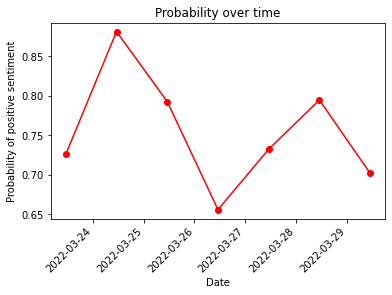

In [313]:
fig, ax = plt.subplots()
ax.plot(result_df.index, result_df['pos_senti_proba'], '-ro')
ax.set_xlabel('Date')
ax.set_ylabel('Probability of positive sentiment')
ax.set_title('Probability over time')
fig.autofmt_xdate(rotation=45)


The average score each day is greater than 0.5 which shows that people are talking positively about the shopify brand. There are days when score went down but overall it stayed above 0.5. If we see that the score is low for a day, we can go back and get the tweets for that day to see if there are negative feedbacks towards our brand.    


## Conclusion

In this notebook we scrapped data from twitter to test our logistic regression model. A similar process can be followed to test other models. We also evaluated daily sentiment score for shopify brand in our study.     

In the next file `6_Streamlit_App` we will put everything together and make an app that will take brand as an input show the user sentiment about their brand over last 7 days.    

